In [2]:
import pandas as pd
import datetime
from WindPy import w
import requests
from Portfolio import portfolio
import time
import matplotlib.pyplot as plt
import easytrader
import pprint
import math

In [3]:
def rounddown(x, n):
    return int(math.floor(x / n)) * n

# 1. Connect to Wind and 华泰

In [4]:
# start WInd
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

# 2. Get the current position

## Set up position template
## Our desired funds
### 1. 160325.SZ 华夏创业 2022/7/24
### 2. 160926.SZ 创业大成 2022/7/16
### 3. 501080.SH 科创中金 2022/7/11
### 4. 501082.SH 科创投资 2022/6/27
### 5. 506002.SH 易基科创 2022/7/28
### 6. 506003.SH 富国科创 2022/7/29
### 7. 506006.SH 添富科创 2022/7/28

In [9]:
position = {
    "160325":{
        "name":"华夏创业",
        "ticker":"160325.SZ",
        "price":w.wsq('160325.SZ', 'rt_last').Data[0][0],
        "shares":0,
        "expiration":(datetime.datetime(2022, 7, 24, 0, 0, 0) - datetime.datetime.now()).days/365
    }, 
    "160926":{
        "name":"创业大成",
        "ticker":"160926.SZ",
        "price":w.wsq('160926.SZ', 'rt_last').Data[0][0],
        "shares":0,
        "expiration":(datetime.datetime(2022, 7, 16, 0, 0, 0) - datetime.datetime.now()).days/365
    }, 
    "501080":{
        "name":"科创中金",
        "ticker":"501080.SH",
        "price":w.wsq('501080.SH', 'rt_last').Data[0][0],
        "shares":0,
        "expiration":(datetime.datetime(2022, 7, 11, 0, 0, 0) - datetime.datetime.now()).days/365
    },
    "501082":{
        "name":"科创投资",
        "ticker":"501082.SH",
        "price":w.wsq('501082.SH', 'rt_last').Data[0][0],
        "shares":0,
        "expiration":(datetime.datetime(2022, 6, 27, 0, 0, 0) - datetime.datetime.now()).days/365
    },
    "506002":{
        "name":"易基科创",
        "ticker":"506002.SH",
        "price":w.wsq('506002.SH', 'rt_last').Data[0][0],
        "shares":0,
        "expiration":(datetime.datetime(2022, 7, 28, 0, 0, 0) - datetime.datetime.now()).days/365
    },
    "506003":{
        "name":"富国科创",
        "ticker":"506003.SH",
        "price":w.wsq('506003.SH', 'rt_last').Data[0][0],
        "shares":0,
        "expiration":(datetime.datetime(2022, 7, 29, 0, 0, 0) - datetime.datetime.now()).days/365
    },
    "506006":{
        "name":"添富科创",
        "ticker":"506006.SH",
        "price":w.wsq('506006.SH', 'rt_last').Data[0][0],
        "shares":0,
        "expiration":(datetime.datetime(2022, 7, 28, 0, 0, 0) - datetime.datetime.now()).days/365
    },
}

ht_position = user.position

for holding in ht_position:
    if holding['证券代码'] in position.keys():
        position[holding['证券代码']]['shares'] = round(holding['市值']/holding['市价'], -2)
        
fee = 0.00003

## Read 华泰 position and balance

In [10]:
log_df = pd.DataFrame()

In [11]:
threshold = 1.5
interval = 60

In [24]:
dt = datetime.datetime.now()

while dt.time() < datetime.time(15):

    print(dt.time())
    now = datetime.datetime.now()

    # 1. create snapshot to document price and NAV
    snapshot = {now : {}}
    for code, info in position.items():

        headers = {
            'content-type': 'application/json',
            'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:22.0) Gecko/20100101 Firefox/22.0'
        }

        response = requests.get(f'https://fundgz.1234567.com.cn/js/{code}.js', headers=headers)
        NAV = float(eval(response.text.replace('jsonpgz(', '').replace(');', ''))['gsz'])

        Price = w.wsq(info['ticker'], 'rt_last').Data[0][0]
        info['price'] = Price
        AnnualizedRateOfReturn = round(((NAV/Price)**(1/info['expiration'])-1)*100, 2)
        #NAV, Price, AnnualizedRateOfReturn
        snapshot[now][code + ' NAV'] = NAV
        snapshot[now][code + ' Price'] = Price
        snapshot[now][code + ' AnnualizedRateOfReturn (%)'] = AnnualizedRateOfReturn

    in_ranks = {k:v for k,v in snapshot[now].items() if "AnnualizedRateOfReturn (%)" in k and position[k.split(' ')[0]]['shares'] != 0}
    out_ranks = {k:v for k,v in snapshot[now].items() if "AnnualizedRateOfReturn (%)" in k and position[k.split(' ')[0]]['shares'] == 0}
    in_ranks = {k.split(' ')[0]:snapshot[now][k] for k in sorted(in_ranks, key=in_ranks.get, reverse=True)}        
    out_ranks = {k.split(' ')[0]:snapshot[now][k] for k in sorted(out_ranks, key=out_ranks.get, reverse=True)}
    print("Holdings: ")
    print(in_ranks)
    print("Not in holdings: ")
    print(out_ranks)

    # 2. Trade
    if list(out_ranks.items())[0][1] - list(in_ranks.items())[-1][1] >= threshold:
        sale = list(in_ranks.items())[-1][0]
        purchase = list(out_ranks.items())[0][0]
        print(f"Sell {sale} Buy {purchase}")
        
        for fund in user.position:
            if fund['证券代码'] == sale:
                check_sale = fund
                
        for fund in user.position:
            if fund['证券代码'] == purchase:
                check_purchase = fund
        
        sell_price = position[sale]['price']
        sell_result = user.sell(sale, price=sell_price, amount=check_sale['股票余额'])
        print("Sell: ", sell_result, "Price: ", sell_price, "Shares: ", check_sale['股票余额'])
        
        time.sleep(60)
        
        while True:
            print(check_sale['证券代码'], check_sale['股票余额'])
            if check_sale['股票余额'] == 0:
                break
            else:
                user.cancel_entrust(sell_result["entrust_no"])
                sell_price = sell_price - 0.001
                sell_result = user.sell(sale, price=sell_price, amount=check_sale['股票余额'])
                print("Sell: ", sell_result, "Price: ", sell_price, "Shares: ", check_sale['股票余额'])

            time.sleep(60)
            
            for fund in user.position:
                if fund['证券代码'] == sale:
                    check_sale = fund

        buy_price = position[purchase]['price']
        purchase_amount = rounddown((user.balance['可用金额'] * fee)/buy_price, 100)
        buy_result = user.buy(purchase, price=buy_price, amount=purchase_amount)
        print("Buy: ", buy_result, "Price: ", buy_price, "Shares: ", purchase_amount) 
        
        time.sleep(60)
        
        while True:
            purchase_amount = rounddown((user.balance['可用金额'] * fee)/buy_price, 100)
            print(check_purchase['证券代码'], check_purchase['股票余额'])
            if purchase_amount == 0:
                break
            else:
                user.cancel_entrust(buy_result["entrust_no"])
                buy_price = buy_price + 0.001
                buy_result = user.buy(purchase, price=buy_price, amount=purchase_amount)
                print("Buy: ", buy_result, "Price: ", buy_price, "Shares: ", purchase_amount)

            time.sleep(60)
            
            for fund in user.position:
                if fund['证券代码'] == purchase:
                    check_purchase = fund

    ht_position = user.position

    for holding in ht_position:
        if holding['证券代码'] in position.keys():
            position[holding['证券代码']]['shares'] = round(holding['市值']/holding['市价'], -2)

    time.sleep(interval)
            
    dt = datetime.datetime.now()

    log_df = pd.concat([log_df, pd.DataFrame(snapshot).T], axis=0)

14:56:47.731576
Holdings: 
{'160926': 13.93, '506006': 13.82, '160325': 13.7, '506003': 13.51}
Not in holdings: 
{'506002': 12.69, '501082': 12.65, '501080': 12.21}
14:57:53.498700
Holdings: 
{'506006': 13.87, '160926': 13.83, '160325': 13.7, '506003': 13.53}
Not in holdings: 
{'506002': 12.69, '501082': 12.59, '501080': 12.19}
14:58:58.491011
Holdings: 
{'160926': 13.92, '506006': 13.87, '160325': 13.79, '506003': 13.44}
Not in holdings: 
{'501082': 12.6, '506002': 12.56, '501080': 12.2}


<AxesSubplot:>

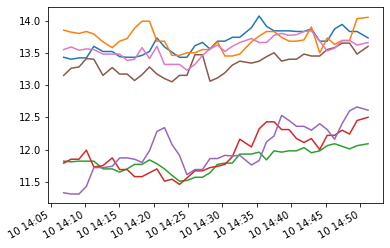

In [23]:
log_df['160325 AnnualizedRateOfReturn (%)'].plot()
log_df['160926 AnnualizedRateOfReturn (%)'].plot()
log_df['501080 AnnualizedRateOfReturn (%)'].plot()
log_df['501082 AnnualizedRateOfReturn (%)'].plot()
log_df['506002 AnnualizedRateOfReturn (%)'].plot()
log_df['506003 AnnualizedRateOfReturn (%)'].plot()
log_df['506006 AnnualizedRateOfReturn (%)'].plot()

<AxesSubplot:>

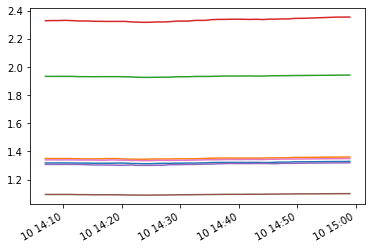

In [25]:
log_df['160325 NAV'].plot()
log_df['160926 NAV'].plot()
log_df['501080 NAV'].plot()
log_df['501082 NAV'].plot()
log_df['506002 NAV'].plot()
log_df['506003 NAV'].plot()
log_df['506006 NAV'].plot()

<AxesSubplot:>

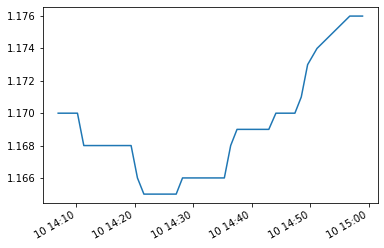

In [28]:
log_df['160325 Price'].plot()

In [30]:
headers = {
    'content-type': 'application/json',
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:22.0) Gecko/20100101 Firefox/22.0'
}

response = requests.get('https://fundgz.1234567.com.cn/js/160926.js', headers=headers)
NAV = float(eval(response.text.replace('jsonpgz(', '').replace(');', ''))['gsz'])

In [32]:
eval(response.text.replace('jsonpgz(', '').replace(');', ''))

{'fundcode': '160926',
 'name': '大成创业板两年定开混合A',
 'jzrq': '2021-08-09',
 'dwjz': '1.3569',
 'gsz': '1.3613',
 'gszzl': '0.33',
 'gztime': '2021-08-10 15:00'}